In [1]:
import os
import numpy as np
import pandas as pd
# import tensorflow as tf
from biom import load_table
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
#from gneiss.util import match
from scipy.spatial import KDTree
from scipy.stats import rankdata
from skbio.stats.composition import clr, clr_inv, centralize
from sklearn.neighbors import NearestNeighbors, KDTree
from skbio.stats.ordination import OrdinationResults
from scipy.spatial.distance import euclidean
from scipy.stats import spearmanr
from src.evaluate import _edge_roc_curve
import datetime
from matplotlib import rc
import matplotlib
%matplotlib inline

# Evaluate True Positive rate of methods

Since we have annotations, we should be able to do this.

In [2]:
# tools = ['mmvec', 'spearman', 'pearson', 'sparcc', 'phi', 'rho', 'spiec-easi']
tools = ['mmvec']
# fnames = [
#     'mmvec_ranks.csv',
#     'soils_spearman.txt',
#     'soils_pearson.txt',
#     'cor_matrix_soil_SparCC.csv',
#     'prop_matrix_soil_PHI.csv',
#     'prop_matrix_soil_RHO.csv',
#     'weights_soil_SPIECEASI.csv'
# ]
fnames = ['mmvec_ranks.csv']

In [3]:
!ls ./results/other_ranks

cor_matrix_soil_SparCC.csv     prop_matrix_soil_RHO.csv
edgelist_soil_SEmultitest.csv  soils_pearson.txt
mmvec_ranks.csv		       soils_spearman.txt
prop_matrix_soil_PHI.csv       weights_soil_SPIECEASI.csv


In [4]:
select_microbes = ['rplo 1 (Cyanobacteria)', 'rplo 2 (Firmicutes)',
                   'rplo 60 (Firmicutes)', 'rplo 7 (Actinobacteria)']
microcoleus_metabolites = ['(3-methyladenine)', '7-methyladenine', '4-guanidinobutanoate', 'uracil',
                           'xanthine', 'hypoxanthine', '(N6-acetyl-lysine)', 'cytosine',
                           'N-acetylornithine', 'N-acetyl-glutamate', 'succinate',
                           'adenosine', 'guanine', 'adenine']

In [5]:
ranks = pd.read_csv(os.path.join('./results/other_ranks', fnames[0]), index_col=0)

In [6]:
sensitivity = lambda x: x['TP'] / (x['TP'] + x['FN'])
specificity = lambda x: x['TN'] / (x['TN'] + x['FP'])
precision = lambda x: x['TP'] / (x['TP'] + x['FP'])
recall = lambda x: x['TP'] / (x['TP'] + x['FN'])
f1 = lambda x: 2 * x['precision'] * x['recall'] / (x['precision'] + x['recall'])

In [7]:
edges = pd.DataFrame(list(zip(['rplo 1 (Cyanobacteria)'] * len(microcoleus_metabolites),
                              microcoleus_metabolites)), columns=['microbe', 'metabolite'])
edges['direction'] = 'R'

microbes = list(ranks.columns)
metabolites = list(ranks.columns)
other_metabolites = list(set(metabolites) - set(microcoleus_metabolites))

other_edges = pd.DataFrame(other_metabolites, columns=['metabolite'])
other_edges['microbe'] = 'rplo 1 (Cyanobacteria)'
other_edges['direction'] = 0

edges = pd.concat((edges, other_edges), axis=0)
edges = edges[['microbe', 'metabolite', 'direction']]

In [8]:
# read ranks from specified other tools
def read_df(fname):
    if '.txt' in fname:
        return pd.read_table(os.path.join('./results/other_ranks', fname),
                             index_col=0)
    else:
        return pd.read_csv(os.path.join('./results/other_ranks', fname),
                           index_col=0)


rankz = list(map(read_df, fnames))

# read ranks from DML
# rankz.append(pd.read_csv(os.path.join('./results/original_data', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/soil_output', 'dml_ranks_norm.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/original_data_lr', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/boost_original_data', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/xgboost_original_data', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/xgboost_clr', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/xgboost_clr_sep', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/soil_output', 'dml_ranks_lr_clr_sc.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/soil_output', 'dml_ranks_boost.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/soil_output', 'dml_ranks_boost_clr_sc.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/clr', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/clr_sc', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/clr_min', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/clr_sc_min', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/clr_sep', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/clr_sep_min', 'coefficients.tsv'), sep="\t", index_col=0).T)

# rankz.append(pd.read_csv(os.path.join('./results/xgboost_original_data_500trees', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/xgboost_clr_500trees', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/xgboost_clr_sep_500trees', 'coefficients.tsv'), sep="\t", index_col=0).T)

# rankz.append(pd.read_csv(os.path.join('./results/automl_rf_short', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/automl_rf_short_clr', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/automl_xgboost_short', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/automl_xgboost_short_clr', 'coefficients.tsv'), sep="\t", index_col=0).T)
rankz.append(pd.read_csv(os.path.join('./results/automl_rf_long', 'coefficients.tsv'), sep="\t", index_col=0).T)
rankz.append(pd.read_csv(os.path.join('./results/automl_rf_long_clr', 'coefficients.tsv'), sep="\t", index_col=0).T)
rankz.append(pd.read_csv(os.path.join('./results/automl_xgboost_long', 'coefficients.tsv'), sep="\t", index_col=0).T)
rankz.append(pd.read_csv(os.path.join('./results/automl_xgboost_long_clr', 'coefficients.tsv'), sep="\t", index_col=0).T)

In [9]:
def roc_f(ranks, tool):
    r = ranks.T[['rplo 1 (Cyanobacteria)']].loc[metabolites].T
    if tool == 'phi':
        r = 1 / r

    res = _edge_roc_curve(r, edges, k_max=40)
    return res

# Include DML rank names
# tools.append('DML rf')
# tools.append('DML_Norm')
# tools.append('DML lr')
# tools.append('DML lr CLR sc')
# tools.append('DML boost')
# tools.append('DML boost CLR sc')
# tools.append('DML xgboost')
# tools.append('DML xgboost clr')
# tools.append('DML xgboost clr(sep)')
# tools.append('DML CLR')
# tools.append('DML CLR (sc)')
# tools.append('DML CLR (min)')
# tools.append('DML CLR (sc min)')
# tools.append('DML CLR sep')
# tools.append('DML CLR sep (min)')
#
# tools.append('DML xgboost (500t)')
# tools.append('DML xgboost (500t) clr')
# tools.append('DML xgboost (500t) clr(sep)')
#
# tools.append('DML automl rf')
# tools.append('DML automl rf clr')
# tools.append('DML automl xgboost')
# tools.append('DML automl xgboost clr')
tools.append('DML automl rf (long)')
tools.append('DML automl rf clr (long)')
tools.append('DML automl xgboost (long)')
tools.append('DML automl xgboost clr (long)')
rocs = list(map(lambda x: roc_f(x[0], x[1]), zip(rankz, tools)))

In [10]:
for res in rocs:
    for df in res:
        df['TPR'] = df.apply(sensitivity, axis=1)
        df['TNR'] = df.apply(specificity, axis=1)
        df['precision'] = df.apply(precision, axis=1)
        df['recall'] = df.apply(recall, axis=1)
        df['f1_score'] = df.apply(f1, axis=1)

/tmp/ipykernel_10152/1052544215.py:1: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = lambda x: x['TP'] / (x['TP'] + x['FN'])
/tmp/ipykernel_10152/1052544215.py:4: RuntimeWarning: invalid value encountered in double_scalars
  recall = lambda x: x['TP'] / (x['TP'] + x['FN'])
/tmp/ipykernel_10152/1052544215.py:1: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = lambda x: x['TP'] / (x['TP'] + x['FN'])
/tmp/ipykernel_10152/1052544215.py:4: RuntimeWarning: invalid value encountered in double_scalars
  recall = lambda x: x['TP'] / (x['TP'] + x['FN'])
/tmp/ipykernel_10152/1052544215.py:1: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = lambda x: x['TP'] / (x['TP'] + x['FN'])
/tmp/ipykernel_10152/1052544215.py:4: RuntimeWarning: invalid value encountered in double_scalars
  recall = lambda x: x['TP'] / (x['TP'] + x['FN'])
/tmp/ipykernel_10152/1052544215.py:1: RuntimeWarning: invalid value encountered in long_scalars
 

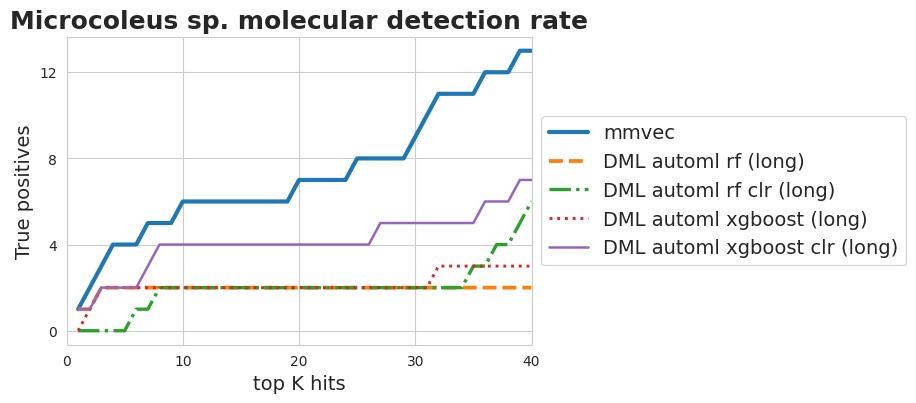

In [11]:
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "b", "g", "r", "y"])
fig, ax = plt.subplots(figsize=(6, 4))
#plt.subplots_adjust(wspace=0.4, hspace=0.5)

for i, (tool, roc) in enumerate(zip(tools, rocs)):
    lw = 3 - 1.5 * i / len(rocs)
    ls = ['-', '--', '-.', ':'][i % 4]
    colors = ["C0", "C4", "C5", "C6", "C7", "C8", "C9"] # colors for xgboost figure
    ax.plot(roc[0]['TP'], label=tool, linewidth=lw, linestyle=ls)
    ax.set_ylabel('True positives', fontsize=14)
    ax.set_xlabel('top K hits', fontsize=14)
    ax.tick_params(axis="x", labelsize=10)
    ax.tick_params(axis="y", labelsize=10)
    ax.set_xlim([0, len(roc[0])])
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

ax.set_title('Microcoleus sp. molecular detection rate', fontsize=18, fontweight='bold')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
# plt.savefig(f"./figures/biocrust_clr_{timestamp}.png", bbox_inches='tight')

In [145]:
rankings = {}
for i in range(len(rankz)):
    print("\n" + tools[i])
    test = rankz[i].T[['rplo 1 (Cyanobacteria)']]
    coeff = test.sort_values('rplo 1 (Cyanobacteria)', ascending=False)
    coeff['rank'] = range(0, coeff.shape[0])
    coeff = coeff.loc[microcoleus_metabolites].sort_values('rank')
    print(coeff)
    rankings[tools[i]] = coeff


mmvec
                      rplo 1 (Cyanobacteria)  rank
adenosine                           5.036277     0
adenine                             4.912609     1
(N6-acetyl-lysine)                  4.389718     2
4-guanidinobutanoate                4.026928     3
cytosine                            3.163511     6
guanine                             3.013095     9
uracil                              1.736077    19
N-acetylornithine                   1.205776    24
(3-methyladenine)                   0.888059    29
succinate                           0.826163    30
xanthine                            0.740586    31
hypoxanthine                        0.645392    35
7-methyladenine                     0.267562    38
N-acetyl-glutamate                 -0.762944    52

DML boost
                      rplo 1 (Cyanobacteria)  rank
adenosine                      212216.060162     0
adenine                        165768.720174     1
N-acetyl-glutamate                421.064998    19
succinate    

In [15]:
table_str = ""
for tool in tools:
    table_str += (tool + " & ")
table_str = table_str[:-2]
table_str += ("\\\ \hline \hline \n")
for i in range(len(rankings[tools[0]])):
    for tool, ranking in rankings.items():
        table_str += (ranking.index[i] + " & ")
    table_str = table_str[:-2]
    table_str += ("\\\ \n")
    for tool, ranking in rankings.items():
        table_str += ("(" + str(ranking['rplo 1 (Cyanobacteria)'][i])[:8] + ")" + " & ")
    table_str = table_str[:-2]
    table_str += ("\\\ \hline \n")

print(table_str)

mmvec & DML rf & DML CLR & DML CLR (sc) & DML CLR (min) & DML CLR (sc min) & DML CLR sep & DML CLR sep (min) \\ \hline \hline 
adenosine & adenosine & cytosine & cytosine & uracil & uracil & xanthine & uracil \\ 
(5.036276) & (503533.6) & (1.064658) & (1.030740) & (0.355653) & (0.357627) & (0.029881) & (0.386932) \\ \hline 
adenine & adenine & N-acetylornithine & (N6-acetyl-lysine) & adenosine & adenosine & 7-methyladenine & adenosine \\ 
(4.912608) & (103739.6) & (1.062162) & (1.015870) & (0.236986) & (0.250599) & (0.028545) & (0.052037) \\ \hline 
(N6-acetyl-lysine) & guanine & (3-methyladenine) & 7-methyladenine & succinate & succinate & (N6-acetyl-lysine) & succinate \\ 
(4.389717) & (2247.888) & (1.057865) & (1.014080) & (0.040323) & (0.046264) & (0.023038) & (0.030963) \\ \hline 
4-guanidinobutanoate & N-acetyl-glutamate & xanthine & N-acetyl-glutamate & N-acetylornithine & adenine & uracil & N-acetylornithine \\ 
(4.026928) & (-133.283) & (1.053658) & (1.013966) & (0.035137) & (

/tmp/ipykernel_28227/250212527.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  table_str += ("(" + str(ranking['rplo 1 (Cyanobacteria)'][i])[:8] + ")" + " & ")


In [205]:
# settings = pd.read_csv('../sim_new/results/DML/automl_xgboost_short/best_models.tsv', sep="\t", index_col=0)
settings = pd.read_csv('./results/automl_xgboost_short/best_models.tsv', sep="\t", index_col=0)

In [206]:
settings

,rplo 1 (Cyanobacteria),rplo 10 (Firmicutes),rplo 100 (Proteobacteria),rplo 101 (Proteobacteria),rplo 102 (Actinobacteria),rplo 103 (Actinobacteria),rplo 104 (Bacteroidetes),rplo 105 (Proteobacteria),rplo 106 (Acidobacteria),rplo 107 (Actinobacteria),...,rplo 90 (Proteobacteria),rplo 91 (Actinobacteria),rplo 92 (Proteobacteria),rplo 93 (Proteobacteria),rplo 94 (unknown),rplo 95 (Proteobacteria),rplo 96 (unknown),rplo 97 (Firmicutes),rplo 98 (Actinobacteria),rplo 99 (Cyanobacteria)
"(2,3-dihydroxy-3-methylbutanoate)","[{'n_estimators': 5, 'max_leaves': 5, 'min_chi...","[{'n_estimators': 4, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 4, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 4, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 4, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 4, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 4, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 4, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 4, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 4, 'max_leaves': 4, 'min_chi...",...,"[{'n_estimators': 4, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 4, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 4, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 4, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 4, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 4, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 4, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 4, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 4, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 6, 'max_leaves': 8, 'min_chi..."
"(2,5-diaminohexanoate)","[{'n_estimators': 4, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 4, 'max_leaves': 10, 'min_ch...","[{'n_estimators': 7, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 10, 'max_leaves': 4, 'min_ch...","[{'n_estimators': 4, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 18, 'max_leaves': 6, 'min_ch...","[{'n_estimators': 4, 'max_leaves': 10, 'min_ch...","[{'n_estimators': 4, 'max_leaves': 17, 'min_ch...","[{'n_estimators': 4, 'max_leaves': 10, 'min_ch...","[{'n_estimators': 4, 'max_leaves': 10, 'min_ch...",...,"[{'n_estimators': 5, 'max_leaves': 7, 'min_chi...","[{'n_estimators': 7, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 7, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 7, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 7, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 7, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 7, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 7, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 7, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 7, 'max_leaves': 4, 'min_chi..."
(3-hydroxypyridine),"[{'n_estimators': 4, 'max_leaves': 15, 'min_ch...","[{'n_estimators': 7, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 6, 'max_leaves': 10, 'min_ch...","[{'n_estimators': 7, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 7, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 7, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 4, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 7, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 7, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 7, 'max_leaves': 4, 'min_chi...",...,"[{'n_estimators': 7, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 7, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 15, 'max_leaves': 4, 'min_ch...","[{'n_estimators': 8, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 8, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 8, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 8, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 8, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 8, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 8, 'max_leaves': 4, 'min_chi..."
(3-methyladenine),"[{'n_estimators': 4, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 4, 'max_leaves': 8, 'min_chi...","[{'n_estimators': 4, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 4, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 4, 'max_leaves': 4, 'min_chi...","[{'n_estimators': 4, '

79220
6.362938651855592


{'whiskers': [<matplotlib.lines.Line2D at 0x7fca06723310>,
 'caps': [<matplotlib.lines.Line2D at 0x7fca0668ca50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fca06723bd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fca42cf9a90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fca40e82890>],
 'means': []}

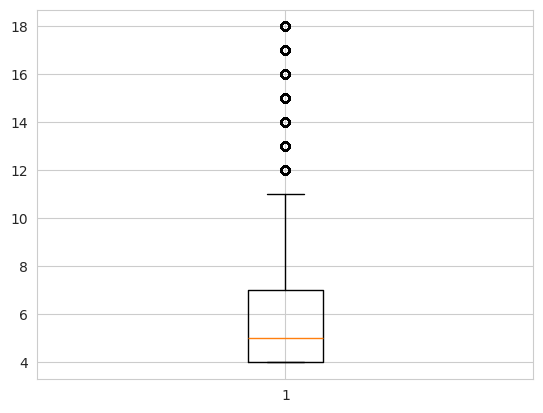

In [207]:
import json
n_estimators = []
for value in settings.values.ravel():
    y = json.loads(value.replace("'", '"'))[0]['n_estimators']
    n_estimators.append(y)
    y = json.loads(value.replace("'", '"'))[1]['n_estimators']
    n_estimators.append(y)
print(len(n_estimators))
print(np.mean(n_estimators))
plt.boxplot(n_estimators)

In [ ]:
n_estimators.append(json.loads(value.replace("'", '"'))[0]['n_estimators'] for value in settings.values.ravel())
n_estimators.append(json.loads(value.replace("'", '"'))[1]['n_estimators'] for value in settings.values.ravel())
print(n_estimators)

In [190]:
y

[{'n_estimators': 5,
  'max_leaves': 5,
  'min_child_weight': 0.0031541182077395877,
  'learning_rate': 0.4564418428158577,
  'subsample': 1.0,
  'colsample_bylevel': 0.43374158282713743,
  'colsample_bytree': 0.7502420094537552,
  'reg_alpha': 0.005614594739012231,
  'reg_lambda': 0.14465041625680328},
 {'n_estimators': 5,
  'max_leaves': 4,
  'min_child_weight': 0.0012207914255426063,
  'learning_rate': 1.0,
  'subsample': 1.0,
  'colsample_bylevel': 0.5153566458737038,
  'colsample_bytree': 0.5998963986211274,
  'reg_alpha': 15.091261717324551,
  'reg_lambda': 0.0009765625}]